In [2]:
import math
import datetime

import click
import numpy as np
import torch
import pandas as pd
from environment import Environment
from parameters import Parameters
from src.classes.dataset import Dataset
from src.max_margin_loss import max_margin_loss
from src.model.conv_model import ConvModel
from src.train_loop import train_loop

from src.metrics import get_recommendation_nids, precision_at_k

from logging_config import get_logger

log = get_logger(__name__)
%load_ext autoreload
%autoreload 2

### Préparation des données et du modèle

In [3]:
environment = Environment()
parameters = Parameters({
    'aggregator_hetero': 'mean',
    'aggregator_type': 'mean',
    'clicks_sample': 0.3,
    'delta': 0.266,
    'dropout': 0.01,
    'hidden_dim': 256,
    'out_dim': 128,
    'embedding_layer': True,
    'edge_batch_size': 3000000,
    'embedding_batch_size': 2048,
    'lr': 0.00017985194246308484,
    'n_layers': 4,
    'neg_sample_size': 2000,
    'norm': True,
    'use_popularity': True,
    'weight_popularity': 0.5,
    'days_popularity': 7,
    'purchases_sample': 0.5,
    'prediction_layer': 'cos',
    'use_recency': True,
    'num_workers': 1,
    "partial_sampling_num_neighbors" : 5,
    'num_epochs': 20,
    'remove': 0.5,
    'use_neighbor_sampling': 1
})


In [ ]:
# Create full train set
dataset = Dataset(
    environment, parameters
)

In [44]:
dataset.articles_in_prediction_nid

array([    0,     1,     2, ..., 11988, 11989, 11990], dtype=int32)

In [45]:
articles_in_history_ids = dataset.purchase_history.sort_values('article_nid')['article_nid'].unique()
articles_in_history_ids[0:len(dataset.articles_in_prediction_nid)]

array([    0,     1,     2, ..., 11988, 11989, 11990])

In [27]:
        
dataset._articles_in_prediction_nid = dataset.purchases_to_predict.sort_values('article_nid')['article_nid'].unique()
dataset._customers_in_prediction_nid = dataset.purchases_to_predict.sort_values('customer_nid')['customer_nid'].unique()

In [34]:
articles_in_history_ids = dataset.purchase_history.sort_values('article_nid')['article_nid'].unique()
customers_in_history_ids = dataset.purchase_history.sort_values('customer_nid')['customer_nid'].unique()

array([ True,  True,  True, ...,  True,  True,  True])

In [19]:
articles_in_history_ids[0: len(dataset.articles_in_prediction_nid)]

array([    0,     1,     2, ..., 15603, 15604, 15605])

In [30]:
(articles_in_history_ids == np.arange(0, len(dataset.articles_in_prediction_nid)))

/tmp/ipykernel_11473/1488867588.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  (articles_in_history_ids == np.arange(0, len(dataset.articles_in_prediction_nid)))


False

In [8]:
from src.classes.graphs import Graphs

graphs = Graphs(dataset, parameters)

In [9]:
from src.get_dimension_dictionnary import get_dimension_dictionnary

dim_dict = get_dimension_dictionnary(graphs, parameters)
dim_dict

{'customer': 19, 'article': 140, 'edge': 5, 'out': 128, 'hidden': 256}

In [10]:
from src.classes.dataloaders import DataLoaders

dataloaders = DataLoaders(graphs,
                    dataset,
                    parameters,
                    environment
                    )

Batch size:  1499


In [29]:
model = ConvModel(dim_dict,
                    parameters
                    )

In [8]:
model.to(environment.device)
model.user_embed.to(environment.device)
model.item_embed.to(environment.device)
model.layers[0] = model.layers[0].to(environment.device)
model.layers[1] = model.layers[1].to(environment.device)
model.layers[2] = model.layers[2].to(environment.device)
model.layers[3] = model.layers[3].to(environment.device)

In [8]:

opt = parameters.optimizer(model.parameters(),
                            lr=parameters.lr)
#embeddings = model.get_embeddings(graphs.history_graph, {
#                'article': graphs.history_graph.nodes['article'].data['features'],
#                'customer': graphs.history_graph.nodes['customer'].data['features'],
#            })
#
model.train()

opt.zero_grad()

In [32]:
graphs.full_graph.nodes['article'].data['h'] = torch.rand(48982, 128)
graphs.full_graph.nodes['customer'].data['h'] = torch.rand(30251, 128)

In [33]:
for inputs, pos_g, neg_g, blocks in dataloaders.dataloader_train_loss:
    break


In [47]:
np.array([True, False, True]).min()

False

In [ ]:
model.get_embeddings(blocks, blocks[0].srcdata['features'])

In [ ]:
trained_model, viz, best_metrics = train_loop(
    model=model,
    graphs=graphs,
    dataset=dataset,
    dataloaders=dataloaders,
    loss_fn=max_margin_loss,
    get_metrics=True,
    parameters=parameters,
    environment=environment,
)

### Test de la boucle de recommandation

In [4]:
environment = Environment()
environment.transactions_path = "../pickles/transactions_sampled.pkl"
parameters = Parameters({})

dataset = Dataset(environment, parameters)


Number of customer in train set :  10162
Number of customer in Valid set :  2540


In [5]:
# Préparation d'un dataset avec des vecteurs
predictions = dataset.purchased_list.copy()
predictions[predictions['length'] > 1]

,customer_nid,articles,length
6,6,"[1272, 466]",2
13,13,"[4961, 5126]",2
16,16,"[2684, 1267, 5792]",3
18,18,"[737, 161, 4706, 850]",4
28,28,"[715, 3877]",2
...,...,...,...
12667,12667,"[1809, 5281]",2
12668,12668,"[377, 976, 46]",3
12672,12672,"[201, 1692, 31, 1595]",4
12674,12674,"[1407, 1608]",2


In [6]:
# Vérifie que les nid des articles sont bien contigües
nb_articles = dataset.articles_in_prediction_nid.shape[0]
assert (dataset.articles_in_prediction_nid == np.arange(0, nb_articles)).min() == True

In [15]:
### Création de vecteurs de score vide pour chacun des clients

def full_score_tensor(x):
    tensor = torch.zeros(nb_articles)
    for i in x['articles']:
        tensor[i] = 0.5
        
    return tensor.reshape(1, nb_articles)

def full_minus(x, amount = 1):
    tensor = full_score_tensor(x)
    
    for i in range(amount):
        false_index = np.random.randint(0, nb_articles)
        tensor[0, false_index] = 1

    return tensor

def only_one(x):
    tensor = torch.zeros(nb_articles)
    tensor[x['articles'][0]] = 0.5
        
    return tensor.reshape(1, nb_articles)

# Aléatoire
predictions['random'] = predictions.apply(lambda x: torch.rand(nb_articles).reshape(1, nb_articles), axis = 1)

# Score de 1
predictions['full'] = predictions.apply(lambda x: full_score_tensor(x), axis = 1)
predictions['full_minus_one'] = predictions.apply(lambda x: full_minus(x, 1), axis = 1)
predictions['full_minus_three'] = predictions.apply(lambda x: full_minus(x, 3), axis = 1)
predictions['only_one'] = predictions.apply(lambda x: only_one(x), axis = 1)


# Créer les tenseurs.
random = torch.cat(predictions['random'].values.tolist())
full =  torch.cat(predictions['full'].values.tolist())
full_minus_one = torch.cat(predictions['full_minus_one'].values.tolist())
full_minus_three = torch.cat(predictions['full_minus_three'].values.tolist())
only_one = torch.cat(predictions['only_one'].values.tolist())

predictions

,customer_nid,articles,length,random,full,full_minus_one,only_one,full_minus_three
0,0,[1779],1,"[[tensor(0.9904), tensor(0.5876), tensor(0.822...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
1,1,[1372],1,"[[tensor(0.3547), tensor(0.1808), tensor(0.914...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
2,2,[1165],1,"[[tensor(0.1837), tensor(0.0252), tensor(0.400...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
3,3,[48],1,"[[tensor(0.9988), tensor(0.3723), tensor(0.713...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
4,4,[920],1,"[[tensor(0.8381), tensor(0.4164), tensor(0.183...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
...,...,...,...,...,...,...,...,...
12697,12697,[4952],1,"[[tensor(0.5901), tensor(0.1910), tensor(0.699...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
12698,12698,[1624],1,"[[tensor(0.7226), tensor(0.9217), tensor(0.285...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
12699,12699,[3575],1,"[[tensor(0.6441), tensor(0.3522), tensor(0.883...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
12700,12700,[405],1,"[[tensor(0.9409), tensor(0.0816), tensor(0.068...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."


In [18]:
predictions.length.value_counts()

1     10301
2      1859
3       397
4       101
5        28
6        11
7         4
11        1
Name: length, dtype: int64

In [8]:
def score(predictions, customer_nids, cutoff):
    
    recommendations = torch.argsort(predictions, dim=1, descending=True)[customer_nids, 0:cutoff]
    
    return recommendations

In [21]:
# Test des fontions seules
customer_nids = predictions['customer_nid'].unique()
recommendations = score(full_minus_three, customer_nids, 3)

precision = precision_at_k(full, customer_nids, dataset, parameters)
recommendations

tensor([[1129, 4141, 1694],
        [4803, 2283, 5807],
        [3990, 1212, 5071],
        ...,
        [5494,  511, 5147],
        [3462, 2569, 1103],
        [  97,  681, 5476]])

In [41]:
y = {
    'customer': torch.tensor([[1, 1, 1, 1, 1]]).float(),
    'article': torch.tensor([[5, 4, 3, 2, 1]]).float()
}


        
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

cos(
    y['customer'].reshape(-1, 2, 1),
    torch.transpose(y['article'], 0, 1).reshape(1, 2, -1)
)


tensor([[0.7071]])

In [26]:
# Reproduce loop
def get_metrics(pred_list, dataset, all_customer_nids, parameters, customers_per_batch = 200):
    current_index = 0
    length = len(all_customer_nids)

    recommendation_chunks = []
    customer_nids_chunks = []
    precision_list = np.array([])

    while current_index < length :
        
        batch_customer_nids = all_customer_nids[current_index: current_index + customers_per_batch]

        print(f"\rProcessing valid recommendations for customers {current_index} - {current_index + customers_per_batch}                     ", end = "")
        new_recommendations = score(pred_list, batch_customer_nids, cutoff = max(parameters.precision_cutoffs))
        
        recommendation_chunks.append(new_recommendations)
        customer_nids_chunks.append(batch_customer_nids)

        # Calculate precision when the number of chunks is considered as optimal.
        if current_index % 5000 == 0 or current_index + customers_per_batch > length:
            
            recommendations = np.concatenate(recommendation_chunks, axis = 0)
            batch_customer_nids = np.concatenate(customer_nids_chunks, axis = 0)
            
            precision = precision_at_k(recommendations, batch_customer_nids, dataset, parameters)
            
            if precision_list.shape[0] == 0:
                precision_list = np.array([precision])
            else: 
                precision_list = np.append(precision_list, [precision], axis = 0)
            
            recommendation_chunks = []
            customer_nids_chunks = []
        
        current_index += customers_per_batch
        
    return np.mean(precision_list, axis = 0)

In [31]:
get_metrics(random, dataset, dataset.customers_nid_train, parameters)

Processing valid recommendations for customers 10000 - 20000                     

array([0.00026667, 0.00071667, 0.00124167])

In [1]:
opt = parameters.optimizer(model.parameters(),
                            lr=parameters.lr)


NameError: name 'parameters' is not defined

In [46]:
embeddings = model.get_embeddings(graphs.history_graph, {
    'article': graphs.history_graph.nodes['article'].data['features'],
    'customer': graphs.history_graph.nodes['customer'].data['features'],
})

graphs.prediction_graph.nodes['article'].data['h'] = embeddings['article'][0:graphs.prediction_graph.num_nodes('article')]
graphs.prediction_graph.nodes['customer'].data['h'] = embeddings['customer'][0:graphs.prediction_graph.num_nodes('customer')]


In [10]:
torch.autograd.set_detect_anomaly(True)

In [13]:
for _, pos_g, neg_g, blocks in dataloaders.dataloader_train_loss:
    break


pos_score, neg_score = model(pos_g, neg_g, graphs.history_graph, {
    'article': graphs.history_graph.nodes['article'].data['features'],
    'customer': graphs.history_graph.nodes['customer'].data['features'],
})

                                
pos_score = torch.nan_to_num(pos_score, 0)
neg_score = torch.nan_to_num(neg_score, 0)

loss = max_margin_loss(pos_score,
                neg_score,
                parameters=parameters,
                environment=environment
                )

loss.backward()
opt.step()
                    

Embeddings:  tensor([[0.0000, 0.0000, 0.0382,  ..., 0.0000, 0.0061, 0.0831],
        [0.0000, 0.0833, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0164, 0.0000, 0.0855,  ..., 0.0000, 0.0138, 0.1343],
        ...,
        [0.0000, 0.1210, 0.0000,  ..., 0.0711, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0666,  ..., 0.0253, 0.0000, 0.0834],
        [0.0000, 0.0000, 0.0502,  ..., 0.0000, 0.0074, 0.0970]],
       grad_fn=<SliceBackward0>)


In [9]:
model.train_loss_list = []
model.train_precision_list = []
model.train_recall_list = []
model.train_coverage_list = []
model.val_loss_list = []
model.val_precision_list = []
model.val_recall_list = []
model.val_coverage_list = []
best_metrics = {}  # For visualization
max_metric = -0.1
patience_counter = 0  # For early stopping
min_loss = 1.1

opt = parameters.optimizer(model.parameters(),
                            lr=parameters.lr)


### Entraînement (1 itération)

In [10]:
model.predict.to(environment.device)

CosinePrediction()

In [18]:
model.train()
opt.zero_grad()

embeddings = model(graphs.history_graph, {
    'article': graphs.history_graph.nodes['article'].data['features'],
    'customer': graphs.history_graph.nodes['customer'].data['features'],
})

In [19]:
graphs.prediction_graph.nodes['article'].data['h'] = embeddings['article'][0:graphs.prediction_graph.num_nodes('article')]
graphs.prediction_graph.nodes['customer'].data['h'] = embeddings['customer'][0:graphs.prediction_graph.num_nodes('customer')]

In [20]:
pos_score = torch.tensor([]).to(environment.device)
neg_score = torch.tensor([]).to(environment.device)

In [42]:
model.predict.to(environment.device)

CosinePrediction()

In [23]:
for _, pos_g, neg_g, blocks in dataloaders.dataloader_train_loss:
    print(blocks)
    break
    pos_g.to(environment.device)
    neg_g.to(environment.device)
    #
    pos_score = torch.cat([pos_score, model.predict(pos_g).to(environment.device)], dim = 0)
    #
    neg_g.nodes['article'].data['h'] = graphs.history_graph.nodes['article'].data['h'][neg_g.nodes['article'].data['_ID'].long()]
    neg_g.nodes['customer'].data['h'] = graphs.history_graph.nodes['customer'].data['h'][neg_g.nodes['customer'].data['_ID'].long()]
    #
    neg_score = torch.cat([neg_score, model.predict(neg_g).to(environment.device)], dim = 0)
    break


[Block(num_src_nodes={'article': 2937, 'customer': 3691},
      num_dst_nodes={'article': 2937, 'customer': 3691},
      num_edges={('customer', 'buys', 'article'): 0},
      metagraph=[('customer', 'article', 'buys')])]


In [44]:
pos_score = torch.nan_to_num(pos_score, 0)
neg_score = torch.nan_to_num(neg_score, 0)

In [45]:
loss = max_margin_loss(pos_score,
                           neg_score,
                           parameters=parameters,
                           environment=environment
                           )


In [46]:
loss.backward()
opt.step()

### Métrique

In [72]:
customers_per_batch = 200
current_index = 0
length = graphs.prediction_graph.num_nodes('customer')

precision_list = np.array([])
recommendation_chunks = []

while current_index < length :
    
    print(f"\rProcessing recommendations for customers {current_index} - {current_index + customers_per_batch}", end = "")
    new_recommendations = get_recommendation_tensor({
        'article': graphs.prediction_graph.nodes['article'].data['h'].to(environment.device),
        'customer': graphs.prediction_graph.nodes['customer'].data['h'][current_index: current_index + customers_per_batch].to(environment.device),
    }, parameters, environment)
    
    recommendation_chunks.append(new_recommendations)

    customer_nids = range(current_index, current_index + customers_per_batch)


    if current_index % 5000 == 0:
        recommendations = torch.cat(recommendation_chunks, dim = 0)
        
        precision = precision_at_k(recommendations, customer_nids, dataset)
        precision_list = np.append(precision_list, precision)
        
        recommendation_chunks = []
    
    current_index += customers_per_batch
    
precision = np.mean(precision_list)


Processing recommendations for customers 25400 - 25600

KeyboardInterrupt: 

### Compilation des recommandations

In [4]:
parameters.embedding_on_full_set = True

In [5]:
dataset = Dataset(environment, parameters)

In [7]:
from src.classes.graphs import Graphs

graphs = Graphs(dataset)

In [15]:
from src.classes.dataloaders import DataLoaders

dataloaders = DataLoaders(graphs,
                    dataset,
                    parameters,
                    environment
                    )

In [31]:
for input_nodes, output_nodes, blocks in dataloaders.dataloader_embedding:
    embeddings = model.forward(blocks, blocks[0].srcdata['features'])
    
    if 'customer' in output_nodes.keys():
        graphs.history_graph.nodes['customer'].data['h'][output_nodes['customer'].long()] = embeddings['customer']
    
    if 'article' in output_nodes.keys():
        graphs.history_graph.nodes['article'].data['h'][output_nodes['article'].long()] = embeddings['article']
        
    break

layer 0
torch.Size([1000, 256])
torch.Size([3195, 256])
layer 1
torch.Size([1000, 256])
torch.Size([0, 256])
layer 2
torch.Size([1000, 256])
torch.Size([0, 256])
layer 3
torch.Size([1000, 128])
torch.Size([0, 128])


### Interprétation des hyperparamètres

In [3]:
import pandas as pd
search_table = pd.read_pickle("../pickles/search_result_table_first_pass_with_loss.pkl")

In [4]:
search_table.drop(columns = ['precision', 'neighbor_sampling', 'out_dim', 'hidden_dim'], inplace = True, axis = 1)

In [10]:
search_table[(search_table['aggregator_type'] == 'pool_nn_weighted') & (search_table['embed_dim'] == 'Medium')]

,aggregator_hetero,aggregator_type,aggregator_weighted,delta,dropout,embed_dim,embedding_layer,lr,n_layers,neg_sample_size,norm,reduce_article_features,min_loss,lost_patience
0,max,pool_nn_weighted,True,NaN,NaN,Medium,True,NaN,4,NaN,NaN,False,0.06659,False
0,max,pool_nn_weighted,True,0.152946,0.751727,Medium,True,0.000174,3,2915.0,True,NaN,0.09653,False
0,max,pool_nn_weighted,True,0.300000,0.200000,Medium,True,0.000150,3,1250.0,True,False,0.09708,False
0,max,pool_nn_weighted,True,NaN,NaN,Medium,True,0.000150,3,1250.0,True,False,0.10120,True
0,max,pool_nn_weighted,True,NaN,NaN,Medium,True,0.000150,3,1250.0,True,False,0.10120,True
0,mean,pool_nn_weighted,True,0.162357,0.786264,Medium,False,0.003289,3,1140.0,True,NaN,0.10739,True
0,max,pool_nn_weighted,True,0.173276,0.517993,Medium,False,0.000112,3,1104.0,True,NaN,0.13107,True
0,mean,pool_nn_weighted,True,0.255564,0.798053,Medium,True,0.009651,3,1238.0,True,NaN,0.16880,True
0,max,pool_nn_weighted,True,0.312496,0.639559,Medium,True,0.000123,4,1501.0,True,NaN,0.18425,False
0,max,pool_nn_weighted,True,0.341829,0.761851,Medium,True,0.000879,3,2355.0,True,NaN,0.21837,True


In [15]:
import pandas as pd
search_table = pd.read_pickle("../pickles/search_result_table.pkl")
search_table.tail(20)

search_table.drop(columns=['out_dim', 'hidden_dim', 'neighbor_sampling'], axis = 1, inplace = True)
search_table.sort_values('precision', ascending=False).head(20)

,aggregator_hetero,aggregator_type,aggregator_weighted,delta,dropout,embed_dim,embedding_layer,lr,n_layers,neg_sample_size,norm,reduce_article_features,lost_patience,min_loss,precision
0,max,pool_nn_weighted,True,0.170380,0.214797,Large,True,0.000360,2,2194,True,True,True,0.102422,0.031205
0,max,pool_nn,False,0.198930,0.234061,Small,True,0.000127,2,1840,True,False,True,0.149923,0.030357
0,mean,pool_nn,False,0.330916,0.231267,Small,True,0.000460,3,1025,False,False,True,0.224554,0.029016
0,sum,pool_nn,False,0.163194,0.107120,Very Small,True,0.000128,2,2338,True,False,False,0.120248,0.028920
0,mean,pool_nn_weighted,True,0.150000,0.100000,Medium,True,0.000100,2,2353,True,False,False,0.095098,0.028850
0,max,pool_nn,False,0.238132,0.147608,Very Small,True,0.000985,4,1396,False,False,True,0.160739,0.028104
0,max,pool_nn,False,0.220728,0.254943,Small,True,0.000996,2,1226,True,False,True,0.138689,0.027687
0,mean,mean_nn,False,0.157330,0.310368,Medium,True,0.000779,2,2409,False,False,True,0.090618,0.027299
0,mean,pool_nn,False,0.266820,0.102780,Very Small,True,0.000102,2,1092,True,True,False,0.206194,0.026988
0,mean,mean_nn_weighted,True,0.178444,0.297422,Very Large,False,0.000248,2,1684,True,False,False,0.123258,0.026684


In [11]:
search_table[search_table['embed_dim'] == 'Large'].sort_values('precision', ascending=False).head(10)

,aggregator_hetero,aggregator_type,aggregator_weighted,delta,dropout,embed_dim,embedding_layer,lr,n_layers,neg_sample_size,norm,reduce_article_features,lost_patience,min_loss,precision
0,max,pool_nn_weighted,True,0.170380,0.214797,Large,True,0.000360,2,2194,True,True,True,0.102422,0.031205
0,max,pool_nn_weighted,True,0.170380,0.214797,Large,True,0.000360,2,2194,True,False,True,0.099749,0.019985
0,max,pool_nn_weighted,True,0.300000,0.100000,Large,False,0.000150,2,1600,True,False,False,0.189508,0.018667
0,mean,pool_nn_weighted,True,0.178444,0.297422,Large,False,0.000248,2,1684,True,False,False,0.108421,0.017769
0,max,pool_nn_weighted,True,0.300000,0.100000,Large,False,0.000150,3,1250,True,False,True,0.227078,0.014676


In [5]:
search_table.to_pickle("../pickles/search_result_table_backup.pkl")

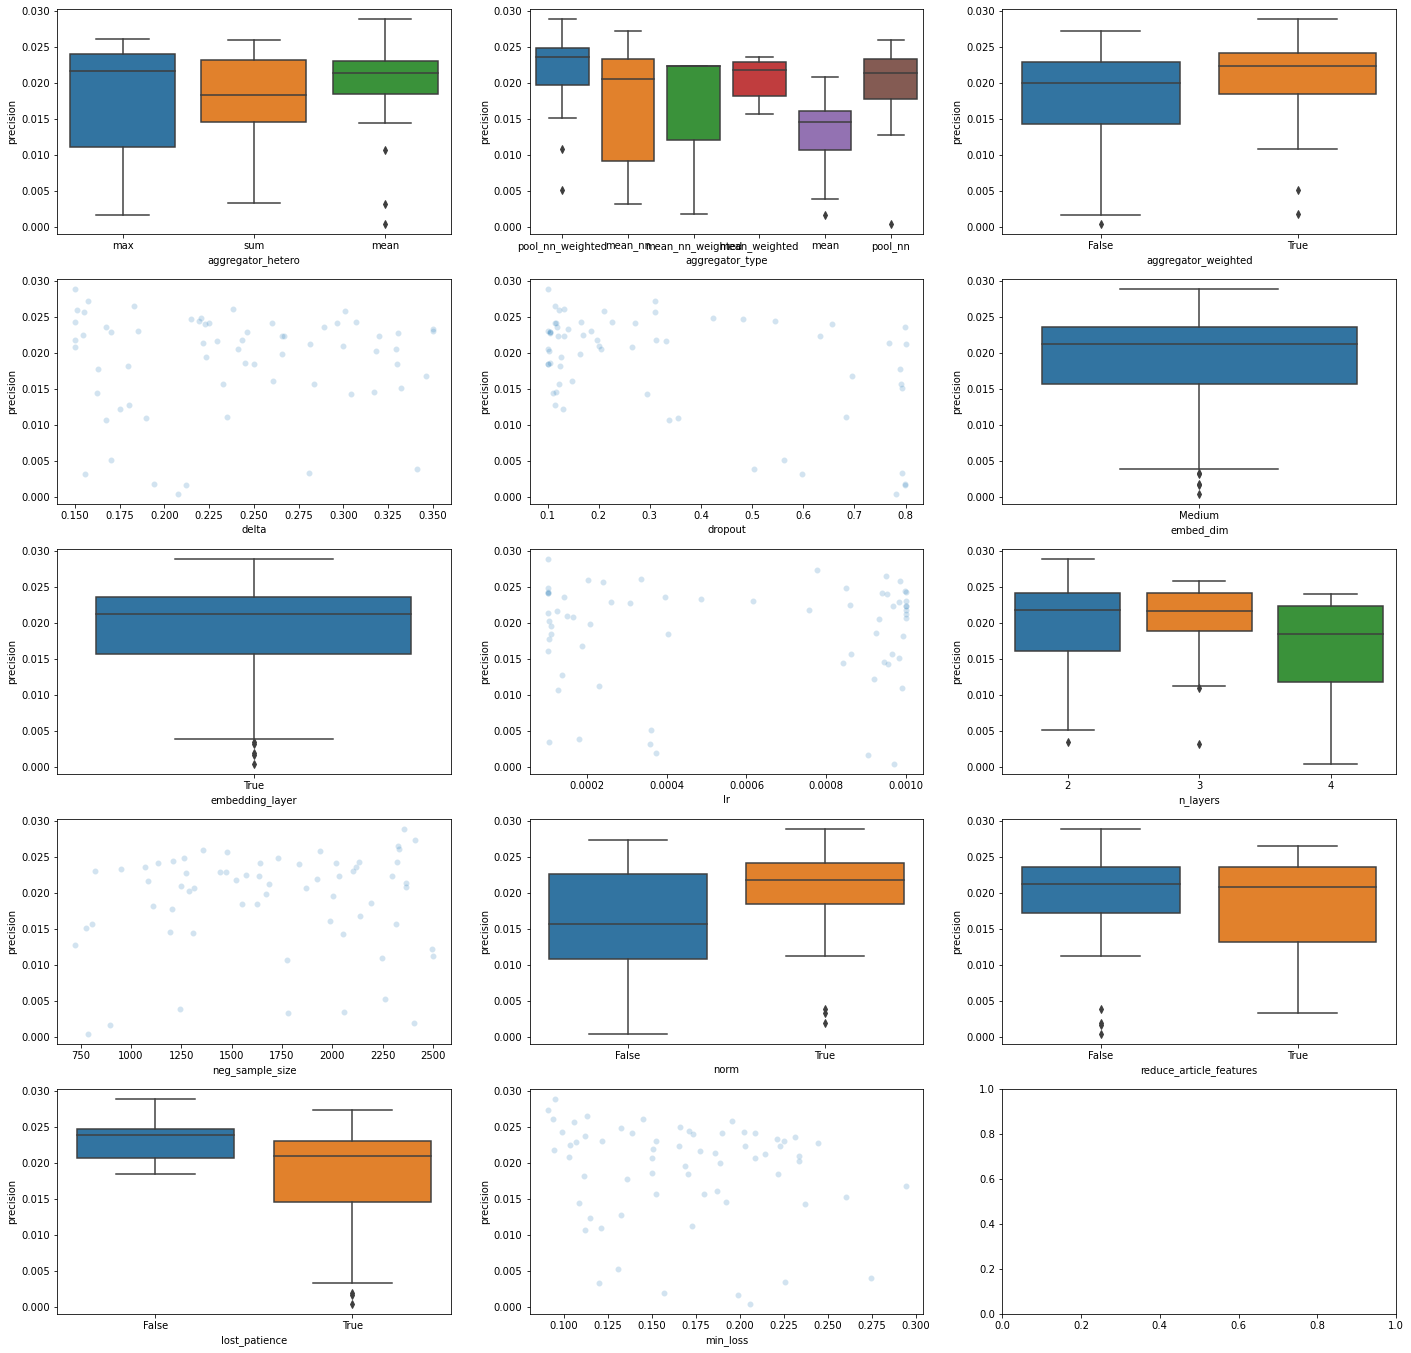

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

search_table_filtered = search_table[search_table['embed_dim'] == 'Small']

non_numeric = ['aggregator_hetero', 'aggregator_type', 'aggregator_weighted', 'embed_dim', 'embedding_layer', 'reduce_article_features', 'n_layers',
       'norm', 'out_dim', 'hidden_dim', 'precision', 'lost_patience']

fig, axes = plt.subplots(5, 3, figsize=(24, 24))

for i in range(len(search_table_filtered.columns) - 1):
       column = search_table_filtered.columns[i]
       if column in non_numeric:
              sns.boxplot(ax = axes[i // 3][i % 3], x = search_table_filtered.columns[i], y = 'precision',  data = search_table_filtered)
       else :
              sns.scatterplot(ax = axes[i // 3][i % 3], x = search_table_filtered.columns[i], y = 'precision', alpha = 0.2, data = search_table_filtered)
              
plt.show()